In [19]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
import itertools
%matplotlib inline
sns.set()

In [37]:
data_sample = pd.read_csv('DataSample__201709211530.csv')
data_sample2 = pd.read_csv('DataSample__201710061552.csv',dtype={"value": str})
#data_sample2['value'] = pd.to_numeric(data_sample2['value'],errors='coerce')
#data_sample['value'] = pd.to_numeric(data_sample['value'],errors='coerce')
data_sample = data_sample.append(data_sample2)
data_sample['startDate'] = pd.to_datetime(data_sample['startDate'])
data_sample['owner'].replace('00000000-5854-8d6f-b8eb-cf14a0f795df','00000000-56ff-538b-2223-e1800b5e3ddb',inplace=True)


types = data_sample['type'].unique()
types

for t in types:
    f = lambda x: float(x.replace(',',''))
    # checks if the values contain decimal points, and uses a float conversion if so
    for v in data_sample.loc[data_sample['type'] == t, 'value'].head():
        if '.' in v:
            f = lambda x: float(x.replace(',',''))
            break
    data_sample.loc[data_sample['type'] == t, 'value'] = data_sample.loc[data_sample['type'] == t, 'value'].map(f)
for col in ['startDate', 'endDate', 'createdAt', 'updatedAt']:
    data_sample[col] = pd.to_datetime(data_sample[col], format='%Y-%m-%d %X')
to_tdelta = lambda row: row['endDate'] - row['startDate']
data_sample['duration'] = data_sample.apply(to_tdelta, axis=1)
data_sample['day_of_week'] = data_sample['startDate'].dt.dayofweek
data_sample.head() #0 - 6 is monday - sunday 

,_id,owner,source,sourceId,sourceName,type,startDate,endDate,value,content,originalData,createdAt,updatedAt,duration,day_of_week
0,1ff0fb89-6e1b-4601-84d0-98c79fdc5f2e,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,A1DB680E-F9C4-4FA4-8818-1D35E398B5F0,Health Mate,health-bmi,2014-08-27 21:41:23,2014-08-27 21:41:23,26.7387,NaN,NaN,2017-08-31 11:20:49,2017-08-31 11:20:49,0 days,2
1,78219621-1da4-4e3b-87bc-f4885718c63f,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,2030515A-1C70-40F3-8470-BDE99ABFC906,Health Mate,health-weight,2014-08-27 21:41:23,2014-08-27 21:41:23,71.042,NaN,NaN,2017-08-31 11:20:58,2017-08-31 11:20:58,0 days,2
2,2d917e7e-0844-4f52-b15e-2a5346c96dda,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,96D21A44-67D7-412D-BF3A-543819A8EBF0,Health Mate,health-bmi,2014-08-28 06:24:53,2014-08-28 06:24:53,26.5866,NaN,NaN,2017-08-31 11:20:49,2017-08-31 11:20:49,0 days,3
3,ab800f4b-bef7-434e-8e57-e0fccc44bfb7,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,5D73FD9D-17E1-480C-9235-3E5036503E6A,Health Mate,health-body-fat,2014-08-28 06:24:53,2014-08-28 06:24:53,0.258699,NaN,NaN,2017-08-31 11:20:53,2017-08-31 11:20:53,0 days,3
4,fb2a0865-17c3-4ac0-a782-749cc7befe12,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,5A9AB03C-30C9-43B9-9742-02E237A6F36D,Health Mate,health-weight,2014-08-28 06:24:53,2014-08-28 06:24:53,70.638,NaN,NaN,2017-08-31 11:20:58,2017-08-31 11:20:58,0 days,3


In [21]:
x1 = data_sample.type
x2 = data_sample.value

types = ['health-bmi','health-body-fat','health-heart-rate','health-sleep','health-weight', 'health-step-count']
type(x1)

pandas.core.series.Series

In [22]:

data_sample['startDate'] = pd.to_datetime(data_sample['startDate'])

bmi = data_sample[data_sample['type'] == 'health-bmi']
bodyfat = data_sample[data_sample['type'] == 'health-body-fat']


bmi.index = bmi['startDate']
bodyfat.index = bodyfat['startDate']


bmi['value'] = pd.to_numeric(bmi['value'])
bmi = bmi.loc[:,'value']
bmi = bmi.resample('D').mean()


bodyfat['value'] = pd.to_numeric(bodyfat['value'])
bodyfat = bodyfat.loc[:,'value']
bodyfat = bodyfat.resample('D').mean()

bmi = bmi.to_frame('bmi')
bmi['bodyfat'] = bodyfat

bmi


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,bmi,bodyfat
startDate,,
2013-11-25,27.188028,0.276388
2013-11-26,26.746608,0.277415
2013-11-27,NaN,NaN
2013-11-28,26.885394,0.285580
2013-11-29,26.455147,0.268143
2013-11-30,26.376778,0.274755
2013-12-01,26.747303,0.263562
2013-12-02,NaN,NaN
2013-12-03,NaN,NaN


In [23]:
corr_linear = bmi['bmi'].corr(bmi['bodyfat'])
corr_linear

0.30769084788819434

In [24]:
corr_nonlinear = bmi['bmi'].corr(bmi['bodyfat'], method='spearman')
corr_nonlinear

0.3814626156706214

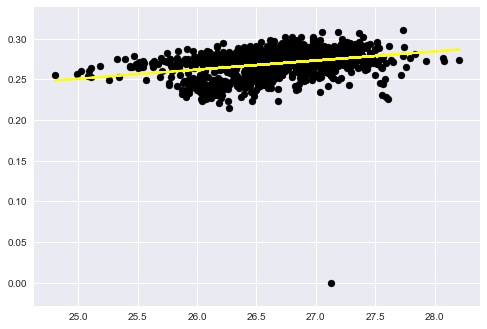

In [25]:
bmi = bmi.dropna()
x = bmi.bmi.values
y = bmi.bodyfat.values
x = x.reshape(len(x), 1)
y = y.reshape(len(x), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

# plot it as in the example at http://scikit-learn.org/
plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='yellow', linewidth=2)

In [26]:
r_squared = regr.score(x, y)
print ("The r^2 value is {}".format(r_squared))

The r^2 value is 0.0946736578742


In [27]:
corr_info = stats.stats.pearsonr(x, y)
r = corr_info[0][0]
p = corr_info[1][0]
print ("The r value for bmi to bodyfat is {} and p is {}".format(r, p))

The r value for bmi to bodyfat is 0.307690847888 and p is 7.14940581065e-24


In [28]:
def prepare_table(x, y):
    steps = data_sample[data_sample['type'] == x]
    bodyfat = data_sample[data_sample['type'] == y]


    steps.index = steps['startDate']
    bodyfat.index = bodyfat['startDate']


    steps['value'] = pd.to_numeric(steps['value'])
    steps = steps.loc[:,'value']
    steps = steps.resample('D').sum()


    bodyfat['value'] = pd.to_numeric(bodyfat['value'])
    bodyfat = bodyfat.loc[:,'value']
    bodyfat = bodyfat.resample('D').mean()

    steps = steps.to_frame('first')
    steps['second'] = bodyfat
    
    return steps

steps = prepare_table('health-step-count', 'health-body-fat')

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


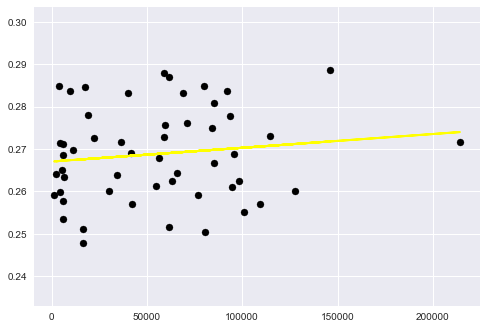

In [29]:
def plotter(steps):
    steps = steps.dropna()
    x = steps['first'].values
    y = steps['second'].values
    x = x.reshape(len(x), 1)
    y = y.reshape(len(x), 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    # plot it as in the example at http://scikit-learn.org/
    plt.scatter(x, y,  color='black')
    plt.plot(x, regr.predict(x), color='yellow', linewidth=2)
    
    corr_info = stats.stats.pearsonr(x, y)
    r = corr_info[0][0]
    p = corr_info[1][0]
    return r, p

r, p = plotter(steps)


In [30]:
print ("The r value for steps to bmi is {} and p is {}".format(r, p))

The r value for steps to bmi is 0.131541761339 and p is 0.352603988863


In [31]:
weight_to_steps = prepare_table('health-weight', 'health-step-count')

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


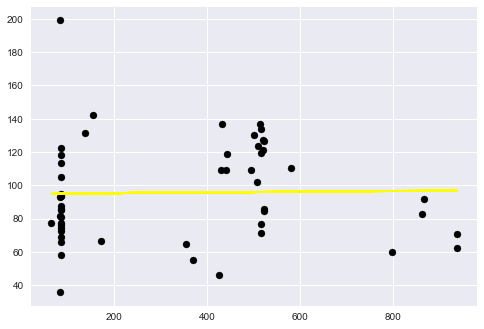

In [32]:
r, p = plotter(weight_to_steps)

In [33]:
print ("The r value for weight to steps is {} and p is {}".format(r, p))

The r value for weight to steps is 0.0184726970442 and p is 0.895547790011


In [34]:
x = np.asarray([float(bmi['bmi'][i]) for i in range(len(bmi['bmi']))])
y = np.asarray([float(bmi['bodyfat'][i]) for i in range(len(bmi['bodyfat']))])

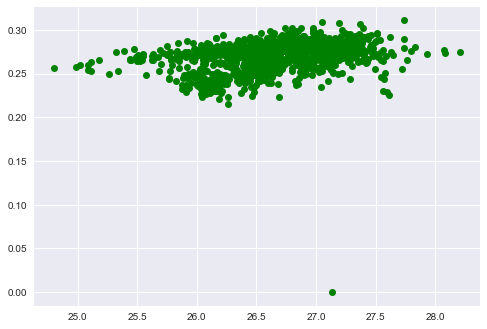

In [35]:
#slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#line = slope*x+intercept
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y, 'go') #, x, fit_fn(x), '--k')
#plt.xlim(0, 5)
#plt.ylim(0, 12)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


The r and p values for health-bmi and health-body-fat are: r = -0.385090580706 and p = 1.66744543674e-37
The r and p values for health-bmi and health-heart-rate are: r = -0.0460741599553 and p = 0.27339945658
The r and p values for health-bmi and health-sleep are: r = 0.077669497768 and p = 0.23659474435
The r and p values for health-bmi and health-weight are: r = -0.690381467239 and p = 5.54468049154e-147
The r and p values for health-bmi and health-step-count are: r = 0.137255043326 and p = 0.331895772847
The r and p values for health-body-fat and health-heart-rate are: r = -0.0405277372165 and p = 0.335395507821
The r and p values for health-body-fat and health-sleep are: r = 0.0819676589067 and p = 0.214557020749
The r and p values for health-body-fat and health-weight are: r = -0.703538483061 and p = 1.24337293809e-153
The r and p values for health-body-fat and health-step-count are: r = 0.139517601995 and p = 0.323910179155
The r and p values for health-heart-rate and health-slee

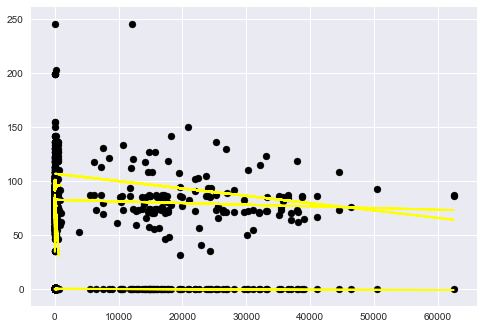

In [36]:
for i in itertools.combinations(types, 2):
    t1 = i[0]
    t2 = i[1]
    a, b = plotter(prepare_table(t1, t2))
    print("The r and p values for {} and {} are: r = {} and p = {}".format(t1, t2, a, b))